Auto-selected test image: img_0001.jpg
Loading Model...


Model loaded successfully!

--- STARTING ANALYSIS ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 759ms/step
DEBUG: Model Output Stats -> Max: 0.4229, Mean: 0.0133


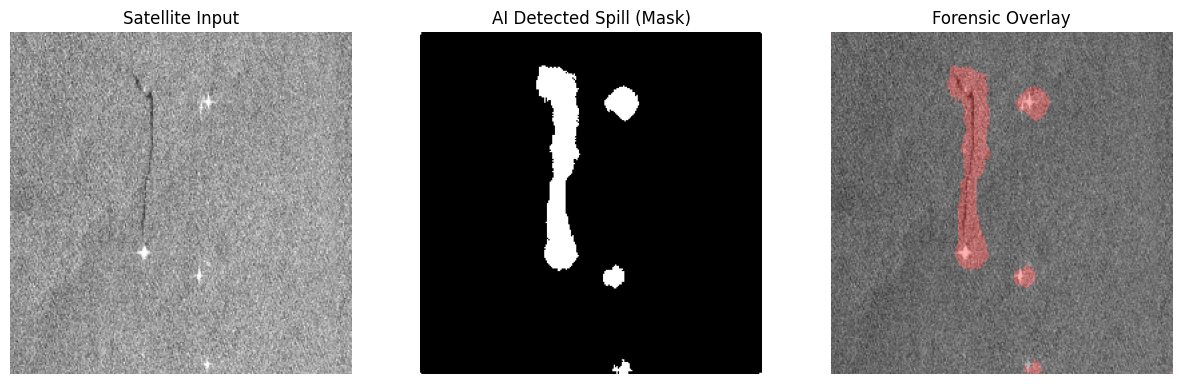


--- DAMAGE ASSESSMENT REPORT ---
Detected Oil Pixels: 3557
Estimated Spill Area:  0.3557 sq. km
SEVERITY: HIGH - Containment booms advised.

--- AIS VESSEL FORENSIC REPORT ---
Searching for ships near Lat: 28.5, Lon: -90.5...
Clear: MILLIE (ID: 368179260) - Speed: 7.3 knots (Moving)
SUSPECT: LOOP LIFTER (ID: 367659880) - Speed: 0.2 knots (STOPPED)
Clear: MISS MARILENE TIDE (ID: 369000000) - Speed: 1.0 knots (Moving)
SUSPECT: SOLITAIRE (ID: 249118000) - Speed: 0.1 knots (STOPPED)
SUSPECT: OCEAN BLACKHAWK (ID: 538005061) - Speed: 0.0 knots (STOPPED)
Clear: WHITETAIL (ID: 367619370) - Speed: 8.8 knots (Moving)
SUSPECT: L/B PAUL (ID: 368681000) - Speed: 0.0 knots (STOPPED)
SUSPECT: NOBLE FAYE KOZACK (ID: 636015856) - Speed: 0.1 knots (STOPPED)
SUSPECT: HOS RUGER (ID: 368264720) - Speed: 0.2 knots (STOPPED)
SUSPECT: LOOP LIFTER (ID: 367659880) - Speed: 0.6 knots (STOPPED)
SUSPECT: HOUSTON (ID: 367663150) - Speed: 0.0 knots (STOPPED)
SUSPECT: SOLITAIRE (ID: 249118000) - Speed: 0.1 knots (ST

In [1]:
# 3_Final_Inference.ipynb

import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.models import load_model

# --- 1. CONFIGURATION ---
MODEL_PATH = '../saved_models/unet_oil_spill.h5' 
AIS_DATA_PATH = '../data/ais_data/vessel_data_clean.csv' 

# AUTOMATICALLY FIND A TEST IMAGE
TEST_DIR = '../data/test/images' 
TEST_IMG_PATH = None

if os.path.exists(TEST_DIR):
    files = os.listdir(TEST_DIR)
    if len(files) > 0:
        TEST_IMG_PATH = os.path.join(TEST_DIR, files[0])
        print(f"Auto-selected test image: {files[0]}")
    else:
        print("WARNING: No images found in '../data/test/images'. Please add one!")
else:
    TEST_IMG_PATH = 'dummy_path.jpg' 

# --- 2. LOAD MODEL ---
print("Loading Model...")
try:
    model = load_model(MODEL_PATH)
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Did you run '1_UNet_Training.ipynb' to generate the .h5 file?")

# --- 3. PREDICT FUNCTION (VISION) ---
def predict_spill(image_path):
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return np.zeros((256,256,3)), np.zeros((256,256,1))

    # Preprocess
    original_img = cv2.imread(image_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    
    img = cv2.resize(original_img, (256, 256))
    # Normalize (Crucial step)
    img_input = np.expand_dims(img, axis=0) / 255.0 
    
    # Predict
    raw_pred = model.predict(img_input)[0]
    
    # Debugging Statistics
    print(f"DEBUG: Model Output Stats -> Max: {np.max(raw_pred):.4f}, Mean: {np.mean(raw_pred):.4f}")

    # Thresholding: Reduced to 0.05 to capture low-confidence spills
    mask_pred = (raw_pred > 0.05).astype(np.uint8) 
    
    return img, mask_pred

# --- 4. ANOMALY DETECTION (DATA LOGIC) ---
def detect_anomaly(ais_csv, spill_lat, spill_lon, search_radius=0.5):
    if not os.path.exists(ais_csv):
        return ["Error: AIS CSV file not found. Run '0_Prepare_AIS.py' first."]

    df = pd.read_csv(ais_csv)
    
    nearby_ships = df[
        (df['LAT'] > spill_lat - search_radius) & 
        (df['LAT'] < spill_lat + search_radius) & 
        (df['LON'] > spill_lon - search_radius) & 
        (df['LON'] < spill_lon + search_radius)
    ]
    
    suspects = []
    
    if nearby_ships.empty:
        suspects.append("No ships found in this area during this time.")
    else:
        for index, ship in nearby_ships.iterrows():
            speed = ship['SOG']
            mmsi = ship['MMSI']
            name = str(ship['VesselName'])
            
            if speed < 1.0: 
                suspects.append(f"SUSPECT: {name} (ID: {mmsi}) - Speed: {speed} knots (STOPPED)")
            else:
                suspects.append(f"Clear: {name} (ID: {mmsi}) - Speed: {speed} knots (Moving)")
            
    return suspects

# --- 5. DAMAGE ASSESSMENT (NEW FEATURE) ---
def assess_damage(mask):
    # 1. Count the number of white pixels (Oil)
    oil_pixel_count = np.count_nonzero(mask)
    
    # 2. Calculate Area based on Satellite Resolution
    # Assumption: Sentinel-1 imagery is approx 10m x 10m per pixel (100 sq meters)
    pixel_area_sq_m = 100 
    
    total_area_m2 = oil_pixel_count * pixel_area_sq_m
    
    # 3. Convert to Square Kilometers
    total_area_km2 = total_area_m2 / 1_000_000
    
    print("\n--- DAMAGE ASSESSMENT REPORT ---")
    print(f"Detected Oil Pixels: {oil_pixel_count}")
    print(f"Estimated Spill Area:  {total_area_km2:.4f} sq. km")
    
    # 4. Define Severity Levels
    if total_area_km2 > 1.0:
        print("SEVERITY: CRITICAL - Large scale cleanup required immediately.")
    elif total_area_km2 > 0.1:
        print("SEVERITY: HIGH - Containment booms advised.")
    elif total_area_km2 > 0.0:
        print("SEVERITY: MODERATE - Minor leakage detected. Monitor closely.")
    else:
        print("SEVERITY: NONE - No oil detected.")

# --- 6. RUN PIPELINE ---
print("\n--- STARTING ANALYSIS ---")

# A. Run Visual Detection
final_img, final_mask = predict_spill(TEST_IMG_PATH)

# B. Run Data Detection (Simulated Coordinates)
simulated_lat = 28.5
simulated_lon = -90.5
anomalies = detect_anomaly(AIS_DATA_PATH, simulated_lat, simulated_lon)

# C. Visualization (With Overlay)
plt.figure(figsize=(15, 5))

# 1. Original
plt.subplot(1, 3, 1)
plt.title("Satellite Input")
plt.imshow(final_img)
plt.axis('off')

# 2. Mask (Multiplied by 255 to show White)
plt.subplot(1, 3, 2)
plt.title("AI Detected Spill (Mask)")
plt.imshow(final_mask * 255, cmap='gray')
plt.axis('off')

# 3. Forensic Overlay (Red Spill on Original)
mask_red = np.zeros_like(final_img)
mask_red[:,:,0] = final_mask[:,:,0] * 255 # Set Red channel
overlay = cv2.addWeighted(final_img, 0.7, mask_red, 0.3, 0)

plt.subplot(1, 3, 3)
plt.title("Forensic Overlay")
plt.imshow(overlay)
plt.axis('off')

plt.show()

# D. Run Damage Assessment
assess_damage(final_mask)

# E. Print AIS Forensic Report
print("\n--- AIS VESSEL FORENSIC REPORT ---")
print(f"Searching for ships near Lat: {simulated_lat}, Lon: {simulated_lon}...")
# Print first 20 suspects
for note in anomalies[:20]:
    print(note)
if len(anomalies) > 20:
    print(f"... and {len(anomalies)-20} more entries.")